Copy rights @Cheng Tang chengtang48@gmail.com

## Plan for numerical simulations

- low-rank data generation: high dimensional, from a subset of coordinates (these are eigenvectors)
- krasulina implementation (done)
- TODO:
    - investigate the effect of dimension and rank
    - investigate perturbed version (optional)
    - compare to Ohad Shamir's SVRG variant of Oja's method (optional)
- Simulation on real data (candidates: MNIST, CCAT?)


# pseodo-code for generalized krasulina
``` 
Input params: init_weights (W^0) (k by d), learning rate schedule (constant and inverse-time), max_iter (T)
While t <= T
 W^{t+1} = W^t + \eta^t W^t x (x - (W^t)^TW^tx)^T
 The step above is equivalent to one SGD update (given that W^t is row orthonormalized) on the objective:
 
 row orthonormalize W^{t+1}
```

In [1]:
!pip install tensorflow

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import tensorflow as tf
import numpy as np
import math

/Users/tcheng/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/tcheng/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# data generators: data should be centered and dispersed around the subspace spanned by gt

def get_train_data(n_train, groundtruth=None):
    """
    gt: d-dimensional vec (non-increasing entries): 
    nonzero at coordinates corresponding to eigenvectors, and the value corresponds eigenvalue
    example: [1,1,0,0,0]
    return: np array train data
    """
    if not groundtruth:
        print("The data generator without groundtruth is not implemented!")
        return
    else:
        train_data = None
        d = len(groundtruth)
        for _ in range(n_train):
            x = np.zeros([1, d])
            for i in range(d):
                if groundtruth[i] > 0 :
                    x[:, i] = np.random.normal(0, groundtruth[i]**0.5)
                else:
                    break
            if train_data is None:
                train_data = x
            else:
                train_data = np.concatenate((train_data, x), axis=0)  
            #print(train_data.shape)
    return train_data

In [4]:
#train_data = get_train_data(5000, groundtruth=[1,1,0])

In [5]:
# test get_train_data
# for i in range(2):
#     ax_mean = np.mean(train_data[:, i])
#     ax_var = np.var(train_data[:, i])
#     print(f"axis {i} mean {ax_mean}")
#     print(f"axis {i} var {ax_var}")

In [6]:
class KrasulinaPCA(object):
    
    def __init__(self, init_weights, train_data, groundtruth=None,
                 learning_rate=[None, 0.0001], mini_batch_size=1, max_iter=100):
        
        self._init_weights = init_weights
        #self._weights = tf.Variable(init_weights, dtype=tf.float64)
        self._train_data = train_data
        #assert learning_rate[0] is None, "Decaying learning rate not implemented yet!"
        self._learning_rate = learning_rate
        #self._minibatch_iter = 0
        #assert groundtruth, "training with real data is not implemented yet!"
        self._groundtruth = groundtruth
        self._k, self._d = init_weights.shape[0], init_weights.shape[1]
        self._mbsize = mini_batch_size
        self._T = max_iter
        self._train_mse_log = list()
            
    def _get_sgd_train_op(self):
        #train_data_placeholder = tf.placeholder(tf.float64, [self._mbsize, self._d])
        return tf.train.GradientDescentOptimizer(self._learning_rate).minimize(
                                                mse_loss_op(self._mini_batch_placeholder, 
                                                self._weights))
    
    def _get_mini_batch_placeholder(self):
        return tf.placeholder(tf.float64, [self._mbsize, self._d])
    
    def _set_train_graph(self):
        """
        Define tf graph
        """
        # tf variables
        self._weights = tf.Variable(self._init_weights, dtype=tf.float64)
        c0, t0 = self._learning_rate
        if c0 is None:
            #signals that learning_rate is constant
            self._learning_rate = tf.Variable(t0, trainable=False)
            self._constant_lr = True
        else:
            # TODO: set inverse-decay schedule
            lr_init = c0 / math.log(t0)
            print(f"Using inverse decay learning rate with initial learning rate {lr_init}")
            self._global_step = tf.Variable(t0, trainable=False)
            self._increment_step_op = tf.assign(self._global_step, self._global_step+1)
            self._learning_rate = c0 / tf.log(tf.to_float(self._global_step))
            #self._learning_rate = tf.Variable(learn_rate, trainable=False)
            self._constant_lr = False
        
        # tf data placeholder
        self._mini_batch_placeholder = self._get_mini_batch_placeholder()
        
        # tf ops
        self._train_op = self._get_sgd_train_op()
        self._ortho_op = get_row_orthonormalize_op(self._weights)
        #print(self._ortho_op, self._weights)
            
        
    def _train(self):
        tf.reset_default_graph()
        # create train log for objective loss (mse)
        self._train_mse_log.append(eval_mse_loss(self._train_data, self._init_weights))
        #if self._groundtruth:
            # create another log for groundtruth metric 
        self._groundtruth_eval_log = list()
        self._groundtruth_eval_log.append(eval_with_groundtruth(self._groundtruth, self._init_weights))
        print(f"The initial mse: {self._train_mse_log[0]}")
        print(f"The initial loss: {self._groundtruth_eval_log[0]}")
        self._set_train_graph()
        mb_iter = 0
        self._epoch = 0
        ## start training
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())            
            for t in range(1, self._T):
                mini_batch, mb_iter = self._get_mini_batch(mb_iter)
                # run optimization
                sess.run([self._train_op] , feed_dict={self._mini_batch_placeholder: mini_batch})
                if self._constant_lr:
                    ## row-normalization of updated weights
                    _, _weights = sess.run([self._ortho_op, self._weights]) 
                else:
                    _, _, _weights = sess.run([self._increment_step_op, self._ortho_op, self._weights])  
                """
                TODO: check that rows of _weights are orthonormal (difference with eye should be small)
                """ 
                ## logging
                self._train_mse_log.append(eval_mse_loss(self._train_data, _weights))
                
                self._groundtruth_eval_log.append(eval_with_groundtruth(self._groundtruth, _weights))
        
    
    def _reset_train_logs(self):
        self._train_log = list()
        self._groundtruth_eval_log = list()
    
    
    def _get_mini_batch(self, mb_iter):
        if mb_iter + self._mbsize < len(self._train_data):
            mini_batch = self._train_data[mb_iter : mb_iter+self._mbsize, :]
            mb_iter_new = mb_iter + self._mbsize
        else:
            self._epoch += 1
            print(f"Finished training {self._epoch}-th epoch")
            mb_iter_new = (mb_iter + self._mbsize) % (len(train_data)-1) - 1
            mini_batch_1 = self._train_data[mb_iter :, :]
            mini_batch_2 = self._train_data[: mb_iter_new, :]
            if mini_batch_2.size > 0:
                mini_batch = mini_batch_1
            else:
                mini_batch = np.concatenate((mini_batch_1, mini_batch_2), axis=0)
        return mini_batch, mb_iter_new
        
              
def mse_loss_op(data_placeholder, weights):
    """
    Input: tf place holder, data_placeholder: n by d, tf variable, weights: k by d
    """
    #print("minibatch shape",data_placeholder.get_shape()[0].value, data_placeholder.get_shape()[1].value)
    encoder = tf.matmul(data_placeholder, weights, transpose_b=True)
    decoder = tf.matmul(encoder, weights)
    #print("decoder shape", decoder.get_shape()[0].value, decoder.get_shape()[1].value)
    return tf.reduce_sum(tf.square(data_placeholder - decoder))


def get_row_orthonormalize_op(weights):
    """
    Description: implements Gram-schmidt on rows of the tf weights matrix
    Input: weights as a tf variable: k by d (k <= d)
    Return: orthonormalize operation in tf graph
    """
    assert weights.get_shape()[0].value <= weights.get_shape()[1].value, "k cannot exceed d!"
    # add batch dimension for matmul
    ortho_weights = tf.expand_dims(weights[0,:]/tf.norm(weights[0,:]),0)
    for i in range(1, weights.get_shape()[0].value):
        v = weights[i,:]
        # add batch dimension for matmul
        v = tf.expand_dims(v, 0) 
        r = v - tf.matmul(tf.matmul(v, ortho_weights, transpose_b=True), ortho_weights)
        ortho_weights = tf.concat([ortho_weights, r/tf.norm(r)], axis=0)
    return tf.assign(weights, ortho_weights)


def eval_with_groundtruth(groundtruth, weights):
    """
    Input: 
        groundtruth, list in the form [2, 1.4, 1, 0, 0]
        weights, np array, shape k by d (row-orthonormal)
    Return:
        tr(U(I-P)): U-projection matrix of eigenvectors, 
                    P: projection matrix of weights
    """
    #eigenvecs = get_eigenvecs(groundtruth)
    eigenvecs = groundtruth.copy()
    U = np.matmul(eigenvecs.T, eigenvecs)
    P = np.matmul(weights.T, weights)
    I = np.eye(weights.shape[1])
    
    return np.trace(np.matmul(U, I-P))


def get_eigenvecs(groundtruth):
    """
    Input: groundtruth in the form of list [1,1,0]
    Return: np array, eigenvecs: k by d
    """
    d = len(groundtruth)
    eigenvecs = None
    for dim in range(d):
        if groundtruth[dim] > 0:
            eigenvec = np.zeros([1, d])
            eigenvec[:, dim] = 1.0
            if eigenvecs is None:
                eigenvecs = eigenvec
            else:
                eigenvecs = np.concatenate((eigenvecs, eigenvec), axis=0)
        else:
            break
    return eigenvecs


def eval_mse_loss(batch_data, _weights):
    """
    Input: np array, batch_data: n by d, 
           np array, weights: k by d
    """
    projection = np.matmul(batch_data, _weights.T)
    xhat = np.matmul(projection, _weights)
    #print(xhat.shape)
    return np.sum(np.square(batch_data-xhat))


def check_orthonormality(weights):
    """
    TODO: Check that rows of weights are nearly orthonormal
    """
    pass
        
        
    
    

In [7]:
## initializers
def get_random_orthogonal_initializer(k, d, gain=1, seed=None):
    tf.reset_default_graph()
    init_fn = tf.orthogonal_initializer(gain, seed, dtype=tf.float64)
    init_weights = tf.get_variable('init_weights', initializer=init_fn, shape=[k, d])
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())   
        _init_weights = sess.run([init_weights])[0]
    return _init_weights

In [8]:
k=2
d=30
gt = [0] * d
for i in range(k):
    gt[i] = (k - i)**4
_init_weights = get_random_orthogonal_initializer(k, d)
n_train = 5000
eigenvecs = get_eigenvecs(gt)
train_data = get_train_data(n_train, groundtruth=gt)

In [9]:
_init_weights

array([[-0.08239293,  0.05685206,  0.01363484,  0.08991873,  0.02455307,
        -0.07013378,  0.1335225 ,  0.18129012,  0.07906397,  0.12277495,
        -0.101911  , -0.45528635, -0.13008113,  0.01717948, -0.2837383 ,
         0.03691667, -0.05133418,  0.26563036,  0.3080018 , -0.07208868,
        -0.26314917,  0.33430445,  0.13024823,  0.11500393, -0.0653446 ,
         0.01778776, -0.38370088, -0.1297309 ,  0.18343967,  0.02573461],
       [-0.02833149, -0.09897029, -0.00360066, -0.24308957,  0.10599934,
        -0.44921735, -0.12081876,  0.0945361 , -0.17071123, -0.32255992,
        -0.16878842,  0.14707537, -0.26944554,  0.0937933 ,  0.03263224,
         0.22033899, -0.01317553,  0.03236534, -0.08492476,  0.06906943,
        -0.00701681, -0.15729791, -0.07267122,  0.3678095 , -0.0948824 ,
        -0.09175728, -0.3346566 ,  0.1050317 , -0.14836726,  0.19592798]],
      dtype=float32)

In [10]:
T = 7*n_train
#lr = (None, 0.0001) 
lr = (0.001, 10)
algo = KrasulinaPCA(_init_weights, train_data, groundtruth=eigenvecs, learning_rate=lr, max_iter=T)

In [11]:
algo._train()

The initial mse: 83274.17022374585
The initial loss: 1.9793814574368298
Using inverse decay learning rate with initial learning rate 0.0004342944819032518
Finished training 1-th epoch
Finished training 2-th epoch
Finished training 3-th epoch
Finished training 4-th epoch
Finished training 5-th epoch
Finished training 6-th epoch


In [12]:
print(algo._train_mse_log[0], algo._train_mse_log[-1])

83274.17022374585 0.08964833725889344


In [13]:
print(algo._groundtruth_eval_log[0], algo._groundtruth_eval_log[-1])

1.9793814574368298 1.755556151672444e-05


In [ ]:
epoch = 0
gt_eval_epoch_wise = list()
epoch_iters = list()
for t, e in enumerate(algo._groundtruth_eval_log):
    if t % n_train == 0:
        epoch += 1
        gt_eval_epoch_wise.append(e)
        epoch_iters.append(epoch)
    

In [42]:
## train all variations
count = 1
n_train = 5000
algo_meta_dict = {}
for k in [1, 10]:
    for d in [10, 100, 500]:
        algo_list = []
        for eta in [(None, 0.0001/k), (0.001/k, 10)]:
            gt = [0] * d
            for i in range(k):
                gt[i] = (k-i) 
            _init_weights = get_random_orthogonal_initializer(k, d)
            print(f"Runing the {count}-th experiment")
            count += 1
            eigenvecs = get_eigenvecs(gt)
            train_data = get_train_data(n_train, groundtruth=gt)
            T = 8*n_train
            algo_list.append(KrasulinaPCA(_init_weights, train_data, groundtruth=eigenvecs, learning_rate=eta, max_iter=T))
            algo_list[-1]._train()
            print("Initial and final loss")
            print(algo_list[-1]._groundtruth_eval_log[0], algo_list[-1]._groundtruth_eval_log[-1])
        key = (k, d)
        algo_meta_dict[key] = algo_list
            

Runing the 1-th experiment
The initial mse: 4256.341811099203
The initial loss: 0.8820739015936852
Finished training 1-th epoch
Finished training 2-th epoch
Finished training 3-th epoch
Finished training 4-th epoch
Finished training 5-th epoch
Finished training 6-th epoch
Finished training 7-th epoch
Initial and final loss
0.8820739015936852 1.4677418026520783e-06
Runing the 2-th experiment
The initial mse: 5063.787038895772
The initial loss: 0.9892187658697367
Using inverse decay learning rate with initial learning rate 0.0004342944819032518
Finished training 1-th epoch
Finished training 2-th epoch
Finished training 3-th epoch
Finished training 4-th epoch
Finished training 5-th epoch
Finished training 6-th epoch
Finished training 7-th epoch
Initial and final loss
0.9892187658697367 2.7398830577674005e-06
Runing the 3-th experiment
The initial mse: 5150.361254872861
The initial loss: 0.9950700397603214
Finished training 1-th epoch
Finished training 2-th epoch
Finished training 3-th epo

In [43]:
algo_meta_dict.keys()

dict_keys([(1, 10), (1, 100), (1, 500), (10, 10), (10, 100), (10, 500)])

In [32]:
import json

In [34]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
%matplotlib inline

In [ ]:
for k, d in algo_meta_dict.keys():
    for idx in [0, 1]:
        algo_meta_dict[(k, d)][idx]._groundtruth_eval_log

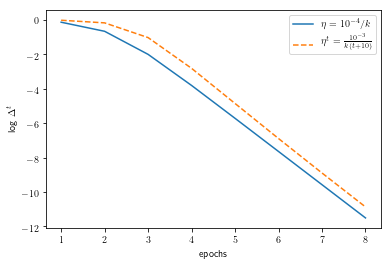

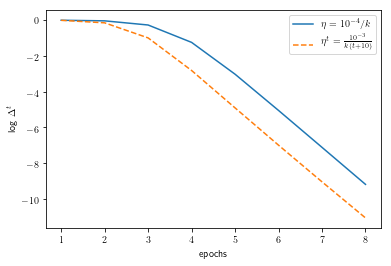

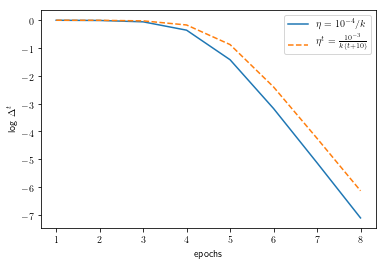

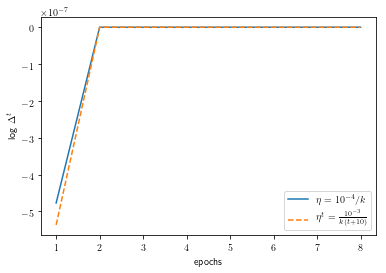

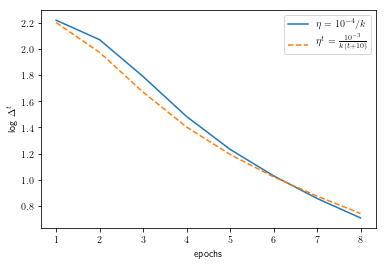

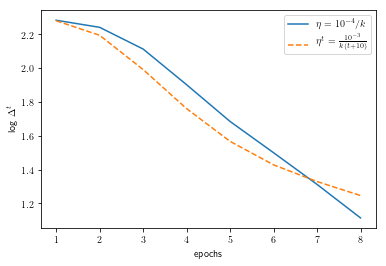

In [56]:
## Plot on all
label_list = [r"$\eta=10^{-4}/k$", r"$\eta^t = \frac{10^{-3}}{k(t+10)}$"]

def get_log(k, d, idx, algo_dict):
    return algo_dict[(k, d)][idx]._groundtruth_eval_log


def plotting(k, d):
    fig=plt.figure()
    for idx in [0, 1]:
        log = get_log(k, d, idx, algo_meta_dict)
        epoch = 0
        gt_eval_epoch_wise = list()
        epoch_iters = list()
        for t, e in enumerate(log):
            if t % n_train == 0:
                epoch += 1
                gt_eval_epoch_wise.append(e)
                epoch_iters.append(epoch)
        #
        #log_epoch_iters = [math.log(t_e) for t_e in epoch_iters]
        log_gt_eval_epoch_wise = [math.log(e) if e > 0 else math.log(e+1) for e in gt_eval_epoch_wise]
        if idx == 1:
            #lr_params = (0.001/k, 10)
            #lr = r"$\frac{0.001}{k(t+10)}$" 
            plt.plot(epoch_iters, log_gt_eval_epoch_wise, '--', label=label_list[idx])
        else:
            #lr = r"\frac{0.0001}{k}"
            plt.plot(epoch_iters, log_gt_eval_epoch_wise, label=label_list[idx])
    plt.legend()
    #plt.title(f"k={k}, d={d}")
    plt.xlabel('epochs')
    plt.ylabel(r'log $\Delta^t$')
    fig.savefig(f"k-{k}-d-{d}.png")

for k, d in algo_meta_dict.keys():
    plotting(k,d)
    


In [55]:
!zip figs.zip pre/*

updating: pre/k-1-d-10.png (deflated 4%)
updating: pre/k-1-d-100.png (deflated 4%)
updating: pre/k-1-d-500.png (deflated 4%)
updating: pre/k-10-d-10.png (deflated 5%)
updating: pre/k-10-d-100.png (deflated 4%)
updating: pre/k-10-d-500.png (deflated 4%)


In [ ]:
import math

iterations = range(T)
log_iterations = [math.log(t+1) for t in iterations]
log_error = [math.log(y) if y > 0 else 0 for y in algo._groundtruth_eval_log]
#const = 100
#theo = [-t + const for t in iterations]

In [ ]:
plt.plot(iterations, log_error)
#plt.plot(iterations, theo)
#plt.plot(log_iterations, log_error)
#plt.plot(iterations, algo._groundtruth_eval_log)
#plt.plot(iterations, algo._train_mse_log)

In [ ]:
log_epoch_iters = [math.log(t_e) for t_e in epoch_iters]
log_gt_eval_epoch_wise = [math.log(e) for e in gt_eval_epoch_wise]
plt.plot(epoch_iters, log_gt_eval_epoch_wise)

In [ ]:
test_arr = [1,2,3]
#print(test_arr[:0])
if test_arr[:1]:
    print("not null")

In [ ]:
x = list(range(1000))
y = [1/float(t+1) for t in x]
y1 = [2**(-t) for t in x]
log_y = [math.log(e) for e in y]
log_y1 = [math.log(e) for e in y1]
plt.plot(x, log_y1)

In [ ]:
## MNIST
!pip install python-mnist

In [ ]:
!git clone https://github.com/sorki/python-mnist

In [ ]:
from mnist import MNIST

In [ ]:
!brew install wget

In [ ]:
%%bash
cd python-mnist
./get_data.sh

In [ ]:
mndata = MNIST('python-mnist/data')
images, labels = mndata.load_training()

In [ ]:
images = np.array([np.array(data) for data in images[:5000]])

In [ ]:
data_mean = np.array(images[0])
data_c = [np.array(images[0])]

for data in images[1:]:
    data_mean += np.array(data)
    data_c.append(np.array(data))
data_mean = data_mean / len(images)

In [ ]:
data_c = np.array(data_c) - data_mean

In [ ]:
data_c.shape

In [ ]:
sigma = 1.0/len(labels) * np.matmul(data_c.T, data_c)

In [ ]:
np.linalg.matrix_rank(sigma, hermitian=True)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA()

In [ ]:
pca.fit(sigma)

In [ ]:
sum(pca.explained_variance_  > 10)

In [ ]:
##
k = 185
d = 784
_init_weights = get_random_orthogonal_initializer(k, d)

In [ ]:
T = 10*n_train
#lr = (None, 0.0001) 
lr = (0.001, 10)
algo = KrasulinaPCA(_init_weights, data_c, groundtruth=pca.components_[:k,:], learning_rate=lr, max_iter=T)

In [ ]:
algo._train()

In [ ]:
print(algo._train_mse_log[0], algo._train_mse_log[-1])
print(algo._groundtruth_eval_log[0], algo._groundtruth_eval_log[-1])

In [ ]:
epoch = 0
gt_eval_epoch_wise = list()
epoch_iters = list()
for t, e in enumerate(algo._groundtruth_eval_log):
    if t % n_train == 0:
        epoch += 1
        gt_eval_epoch_wise.append(e)
        epoch_iters.append(epoch)

In [ ]:
iterations = range(T)
log_iterations = [math.log(t+1) for t in iterations]
log_error = [math.log(y) if y > 0 else 0 for y in algo._groundtruth_eval_log]
plt.plot(iterations, log_error)
#plt.plot(log_iterations, log_error)

In [ ]:
algo._groundtruth_eval_log

In [ ]:
from sklearn import datasets

In [ ]:
X, _ = datasets.load_digits(return_X_y=True)

In [ ]:
X_c = X - np.mean(X, axis=0)

In [ ]:
X_c.shape

In [ ]:
sigma = np.matmul(X.T, X)
np.linalg.matrix_rank(sigma)

In [ ]:
pca=PCA()

In [ ]:
pca.fit(sigma)
pca.explained_variance_

In [ ]:
X = datasets.make_low_rank_matrix(n_samples=100, n_features=100, 
                     effective_rank=10, tail_strength=0.5, random_state=None)

In [ ]:
X_c = X - np.mean(X, axis=0)

In [ ]:
np.linalg.matrix_rank(np.matmul(X.T, X))

In [ ]:
newsgroup = datasets.fetch_20newsgroups_vectorized()

In [ ]:
newsgroup.data.shape

In [ ]:
np.linalg.matrix_rank(newsgroup.data)

In [ ]:
#sigma = np.matmul(newsgroup.data.T, newsgroup.data)